In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.9,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_09_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_1_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 831)
(772408, 8)
validation
(101248, 831)
(101248, 8)
test
(98888, 831)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/773 [..............................] - ETA: 14:50 - loss: 2.0130 - STD: 0.0804 - MAE: 0.2121

 15/773 [..............................] - ETA: 2s - loss: 1.4191 - STD: 0.1890 - MAE: 0.1486   

 31/773 [>.............................] - ETA: 2s - loss: 1.3660 - STD: 0.1916 - MAE: 0.1463

 47/773 [>.............................] - ETA: 2s - loss: 1.3491 - STD: 0.1928 - MAE: 0.1454

 63/773 [=>............................] - ETA: 2s - loss: 1.3386 - STD: 0.1923 - MAE: 0.1453

 78/773 [==>...........................] - ETA: 2s - loss: 1.3345 - STD: 0.1921 - MAE: 0.1453

 94/773 [==>...........................] - ETA: 2s - loss: 1.3319 - STD: 0.1915 - MAE: 0.1456

110/773 [===>..........................] - ETA: 2s - loss: 1.3264 - STD: 0.1915 - MAE: 0.1453

125/773 [===>..........................] - ETA: 2s - loss: 1.3203 - STD: 0.1919 - MAE: 0.1449

139/773 [====>.........................] - ETA: 2s - loss: 1.3120 - STD: 0.1925 - MAE: 0.1444

156/773 [=====>........................] - ETA: 2s - loss: 1.2984 - STD: 0.1934 - MAE: 0.1435

172/773 [=====>........................] - ETA: 1s - loss: 1.2860 - STD: 0.1941 - MAE: 0.1429

189/773 [======>.......................] - ETA: 1s - loss: 1.2724 - STD: 0.1948 - MAE: 0.1422

205/773 [======>.......................] - ETA: 1s - loss: 1.2579 - STD: 0.1957 - MAE: 0.1413

222/773 [=======>......................] - ETA: 1s - loss: 1.2427 - STD: 0.1968 - MAE: 0.1404

240/773 [========>.....................] - ETA: 1s - loss: 1.2281 - STD: 0.1980 - MAE: 0.1395

257/773 [========>.....................] - ETA: 1s - loss: 1.2153 - STD: 0.1988 - MAE: 0.1387

274/773 [=========>....................] - ETA: 1s - loss: 1.2028 - STD: 0.1998 - MAE: 0.1379

291/773 [==========>...................] - ETA: 1s - loss: 1.1899 - STD: 0.2008 - MAE: 0.1371

308/773 [==========>...................] - ETA: 1s - loss: 1.1776 - STD: 0.2018 - MAE: 0.1362

325/773 [===========>..................] - ETA: 1s - loss: 1.1658 - STD: 0.2027 - MAE: 0.1354

343/773 [============>.................] - ETA: 1s - loss: 1.1535 - STD: 0.2038 - MAE: 0.1345

360/773 [============>.................] - ETA: 1s - loss: 1.1425 - STD: 0.2048 - MAE: 0.1337

378/773 [=============>................] - ETA: 1s - loss: 1.1315 - STD: 0.2057 - MAE: 0.1328

396/773 [==============>...............] - ETA: 1s - loss: 1.1214 - STD: 0.2066 - MAE: 0.1321

411/773 [==============>...............] - ETA: 1s - loss: 1.1135 - STD: 0.2073 - MAE: 0.1315

429/773 [===============>..............] - ETA: 1s - loss: 1.1046 - STD: 0.2081 - MAE: 0.1308

447/773 [================>.............] - ETA: 1s - loss: 1.0964 - STD: 0.2089 - MAE: 0.1302

464/773 [=================>............] - ETA: 0s - loss: 1.0891 - STD: 0.2095 - MAE: 0.1297

481/773 [=================>............] - ETA: 0s - loss: 1.0816 - STD: 0.2102 - MAE: 0.1291

497/773 [==================>...........] - ETA: 0s - loss: 1.0755 - STD: 0.2107 - MAE: 0.1286

514/773 [==================>...........] - ETA: 0s - loss: 1.0690 - STD: 0.2114 - MAE: 0.1281

531/773 [===================>..........] - ETA: 0s - loss: 1.0630 - STD: 0.2119 - MAE: 0.1276

547/773 [====================>.........] - ETA: 0s - loss: 1.0572 - STD: 0.2125 - MAE: 0.1272

563/773 [====================>.........] - ETA: 0s - loss: 1.0520 - STD: 0.2129 - MAE: 0.1268

564/773 [====================>.........] - ETA: 0s - loss: 1.0518 - STD: 0.2130 - MAE: 0.1267

579/773 [=====================>........] - ETA: 0s - loss: 1.0473 - STD: 0.2134 - MAE: 0.1264

595/773 [======================>.......] - ETA: 0s - loss: 1.0418 - STD: 0.2139 - MAE: 0.1259

611/773 [======================>.......] - ETA: 0s - loss: 1.0371 - STD: 0.2144 - MAE: 0.1255

627/773 [=======================>......] - ETA: 0s - loss: 1.0324 - STD: 0.2149 - MAE: 0.1252

645/773 [========================>.....] - ETA: 0s - loss: 1.0274 - STD: 0.2153 - MAE: 0.1248

663/773 [========================>.....] - ETA: 0s - loss: 1.0226 - STD: 0.2158 - MAE: 0.1244

679/773 [=========================>....] - ETA: 0s - loss: 1.0187 - STD: 0.2162 - MAE: 0.1240

695/773 [=========================>....] - ETA: 0s - loss: 1.0147 - STD: 0.2166 - MAE: 0.1237

712/773 [==========================>...] - ETA: 0s - loss: 1.0104 - STD: 0.2170 - MAE: 0.1234

728/773 [===========================>..] - ETA: 0s - loss: 1.0068 - STD: 0.2173 - MAE: 0.1231

745/773 [===========================>..] - ETA: 0s - loss: 1.0030 - STD: 0.2177 - MAE: 0.1227

761/773 [============================>.] - ETA: 0s - loss: 0.9995 - STD: 0.2181 - MAE: 0.1224

773/773 [==============================] - 5s 5ms/step - loss: 0.9970 - STD: 0.2183 - MAE: 0.1222 - val_loss: 0.8896 - val_STD: 0.2389 - val_MAE: 0.1053


Epoch 2/10000


  1/773 [..............................] - ETA: 14s - loss: 0.8720 - STD: 0.2396 - MAE: 0.1076

 16/773 [..............................] - ETA: 2s - loss: 0.8465 - STD: 0.2330 - MAE: 0.1100 

 32/773 [>.............................] - ETA: 2s - loss: 0.8472 - STD: 0.2329 - MAE: 0.1101

 47/773 [>.............................] - ETA: 2s - loss: 0.8471 - STD: 0.2332 - MAE: 0.1099

 62/773 [=>............................] - ETA: 2s - loss: 0.8409 - STD: 0.2331 - MAE: 0.1096

 78/773 [==>...........................] - ETA: 2s - loss: 0.8351 - STD: 0.2339 - MAE: 0.1089

 94/773 [==>...........................] - ETA: 2s - loss: 0.8342 - STD: 0.2341 - MAE: 0.1088

110/773 [===>..........................] - ETA: 2s - loss: 0.8314 - STD: 0.2343 - MAE: 0.1086

127/773 [===>..........................] - ETA: 2s - loss: 0.8283 - STD: 0.2346 - MAE: 0.1083

144/773 [====>.........................] - ETA: 2s - loss: 0.8282 - STD: 0.2346 - MAE: 0.1083

162/773 [=====>........................] - ETA: 1s - loss: 0.8273 - STD: 0.2347 - MAE: 0.1082

178/773 [=====>........................] - ETA: 1s - loss: 0.8242 - STD: 0.2350 - MAE: 0.1079

194/773 [======>.......................] - ETA: 1s - loss: 0.8249 - STD: 0.2350 - MAE: 0.1079

211/773 [=======>......................] - ETA: 1s - loss: 0.8236 - STD: 0.2353 - MAE: 0.1077

227/773 [=======>......................] - ETA: 1s - loss: 0.8221 - STD: 0.2354 - MAE: 0.1076

244/773 [========>.....................] - ETA: 1s - loss: 0.8205 - STD: 0.2355 - MAE: 0.1075

260/773 [=========>....................] - ETA: 1s - loss: 0.8188 - STD: 0.2355 - MAE: 0.1074

276/773 [=========>....................] - ETA: 1s - loss: 0.8177 - STD: 0.2358 - MAE: 0.1072

292/773 [==========>...................] - ETA: 1s - loss: 0.8167 - STD: 0.2358 - MAE: 0.1071

308/773 [==========>...................] - ETA: 1s - loss: 0.8151 - STD: 0.2360 - MAE: 0.1070

324/773 [===========>..................] - ETA: 1s - loss: 0.8143 - STD: 0.2361 - MAE: 0.1069

340/773 [============>.................] - ETA: 1s - loss: 0.8132 - STD: 0.2362 - MAE: 0.1068

358/773 [============>.................] - ETA: 1s - loss: 0.8125 - STD: 0.2363 - MAE: 0.1068

375/773 [=============>................] - ETA: 1s - loss: 0.8116 - STD: 0.2364 - MAE: 0.1067

393/773 [==============>...............] - ETA: 1s - loss: 0.8104 - STD: 0.2364 - MAE: 0.1066

409/773 [==============>...............] - ETA: 1s - loss: 0.8088 - STD: 0.2366 - MAE: 0.1064

425/773 [===============>..............] - ETA: 1s - loss: 0.8084 - STD: 0.2367 - MAE: 0.1064

441/773 [================>.............] - ETA: 1s - loss: 0.8071 - STD: 0.2368 - MAE: 0.1063

457/773 [================>.............] - ETA: 1s - loss: 0.8065 - STD: 0.2369 - MAE: 0.1062

474/773 [=================>............] - ETA: 0s - loss: 0.8051 - STD: 0.2370 - MAE: 0.1061

490/773 [==================>...........] - ETA: 0s - loss: 0.8043 - STD: 0.2371 - MAE: 0.1060

507/773 [==================>...........] - ETA: 0s - loss: 0.8037 - STD: 0.2372 - MAE: 0.1059

524/773 [===================>..........] - ETA: 0s - loss: 0.8035 - STD: 0.2372 - MAE: 0.1059

541/773 [===================>..........] - ETA: 0s - loss: 0.8031 - STD: 0.2372 - MAE: 0.1059

557/773 [====================>.........] - ETA: 0s - loss: 0.8024 - STD: 0.2373 - MAE: 0.1058

573/773 [=====================>........] - ETA: 0s - loss: 0.8016 - STD: 0.2374 - MAE: 0.1058

590/773 [=====================>........] - ETA: 0s - loss: 0.8011 - STD: 0.2374 - MAE: 0.1057

607/773 [======================>.......] - ETA: 0s - loss: 0.8000 - STD: 0.2375 - MAE: 0.1056

624/773 [=======================>......] - ETA: 0s - loss: 0.7990 - STD: 0.2376 - MAE: 0.1055

640/773 [=======================>......] - ETA: 0s - loss: 0.7982 - STD: 0.2377 - MAE: 0.1055

656/773 [========================>.....] - ETA: 0s - loss: 0.7974 - STD: 0.2377 - MAE: 0.1054

669/773 [========================>.....] - ETA: 0s - loss: 0.7969 - STD: 0.2378 - MAE: 0.1054

683/773 [=========================>....] - ETA: 0s - loss: 0.7964 - STD: 0.2379 - MAE: 0.1053

699/773 [==========================>...] - ETA: 0s - loss: 0.7955 - STD: 0.2379 - MAE: 0.1052

716/773 [==========================>...] - ETA: 0s - loss: 0.7946 - STD: 0.2380 - MAE: 0.1052

734/773 [===========================>..] - ETA: 0s - loss: 0.7937 - STD: 0.2381 - MAE: 0.1051

748/773 [============================>.] - ETA: 0s - loss: 0.7931 - STD: 0.2381 - MAE: 0.1050

764/773 [============================>.] - ETA: 0s - loss: 0.7923 - STD: 0.2382 - MAE: 0.1049

773/773 [==============================] - 3s 4ms/step - loss: 0.7918 - STD: 0.2383 - MAE: 0.1049 - val_loss: 0.7612 - val_STD: 0.2455 - val_MAE: 0.0982


Epoch 3/10000


  1/773 [..............................] - ETA: 15s - loss: 0.7484 - STD: 0.2455 - MAE: 0.0996

 13/773 [..............................] - ETA: 3s - loss: 0.7475 - STD: 0.2418 - MAE: 0.1013 

 27/773 [>.............................] - ETA: 2s - loss: 0.7492 - STD: 0.2427 - MAE: 0.1007

 40/773 [>.............................] - ETA: 2s - loss: 0.7613 - STD: 0.2422 - MAE: 0.1016

 54/773 [=>............................] - ETA: 2s - loss: 0.7591 - STD: 0.2418 - MAE: 0.1017

 70/773 [=>............................] - ETA: 2s - loss: 0.7556 - STD: 0.2420 - MAE: 0.1013

 86/773 [==>...........................] - ETA: 2s - loss: 0.7525 - STD: 0.2423 - MAE: 0.1010

101/773 [==>...........................] - ETA: 2s - loss: 0.7536 - STD: 0.2423 - MAE: 0.1011

114/773 [===>..........................] - ETA: 2s - loss: 0.7534 - STD: 0.2421 - MAE: 0.1012

129/773 [====>.........................] - ETA: 2s - loss: 0.7548 - STD: 0.2421 - MAE: 0.1014

145/773 [====>.........................] - ETA: 2s - loss: 0.7542 - STD: 0.2421 - MAE: 0.1013

162/773 [=====>........................] - ETA: 2s - loss: 0.7523 - STD: 0.2421 - MAE: 0.1012

178/773 [=====>........................] - ETA: 2s - loss: 0.7516 - STD: 0.2422 - MAE: 0.1012

195/773 [======>.......................] - ETA: 1s - loss: 0.7514 - STD: 0.2423 - MAE: 0.1011

212/773 [=======>......................] - ETA: 1s - loss: 0.7535 - STD: 0.2423 - MAE: 0.1012

227/773 [=======>......................] - ETA: 1s - loss: 0.7540 - STD: 0.2422 - MAE: 0.1013

239/773 [========>.....................] - ETA: 1s - loss: 0.7528 - STD: 0.2422 - MAE: 0.1012

251/773 [========>.....................] - ETA: 1s - loss: 0.7529 - STD: 0.2423 - MAE: 0.1012

263/773 [=========>....................] - ETA: 1s - loss: 0.7543 - STD: 0.2421 - MAE: 0.1014

277/773 [=========>....................] - ETA: 1s - loss: 0.7537 - STD: 0.2421 - MAE: 0.1013

293/773 [==========>...................] - ETA: 1s - loss: 0.7532 - STD: 0.2422 - MAE: 0.1013

309/773 [==========>...................] - ETA: 1s - loss: 0.7527 - STD: 0.2422 - MAE: 0.1012

323/773 [===========>..................] - ETA: 1s - loss: 0.7522 - STD: 0.2423 - MAE: 0.1011

335/773 [============>.................] - ETA: 1s - loss: 0.7517 - STD: 0.2423 - MAE: 0.1011

347/773 [============>.................] - ETA: 1s - loss: 0.7513 - STD: 0.2424 - MAE: 0.1010

361/773 [=============>................] - ETA: 1s - loss: 0.7509 - STD: 0.2424 - MAE: 0.1010

376/773 [=============>................] - ETA: 1s - loss: 0.7503 - STD: 0.2424 - MAE: 0.1010

393/773 [==============>...............] - ETA: 1s - loss: 0.7489 - STD: 0.2425 - MAE: 0.1009

408/773 [==============>...............] - ETA: 1s - loss: 0.7482 - STD: 0.2426 - MAE: 0.1008

421/773 [===============>..............] - ETA: 1s - loss: 0.7477 - STD: 0.2427 - MAE: 0.1007

434/773 [===============>..............] - ETA: 1s - loss: 0.7473 - STD: 0.2427 - MAE: 0.1007

450/773 [================>.............] - ETA: 1s - loss: 0.7470 - STD: 0.2427 - MAE: 0.1007

466/773 [=================>............] - ETA: 1s - loss: 0.7465 - STD: 0.2428 - MAE: 0.1006

482/773 [=================>............] - ETA: 1s - loss: 0.7465 - STD: 0.2428 - MAE: 0.1007

495/773 [==================>...........] - ETA: 0s - loss: 0.7464 - STD: 0.2428 - MAE: 0.1006

511/773 [==================>...........] - ETA: 0s - loss: 0.7458 - STD: 0.2429 - MAE: 0.1006

527/773 [===================>..........] - ETA: 0s - loss: 0.7453 - STD: 0.2429 - MAE: 0.1005

543/773 [====================>.........] - ETA: 0s - loss: 0.7447 - STD: 0.2429 - MAE: 0.1005

558/773 [====================>.........] - ETA: 0s - loss: 0.7449 - STD: 0.2430 - MAE: 0.1005

575/773 [=====================>........] - ETA: 0s - loss: 0.7446 - STD: 0.2430 - MAE: 0.1005

592/773 [=====================>........] - ETA: 0s - loss: 0.7441 - STD: 0.2430 - MAE: 0.1004

609/773 [======================>.......] - ETA: 0s - loss: 0.7439 - STD: 0.2430 - MAE: 0.1004

627/773 [=======================>......] - ETA: 0s - loss: 0.7435 - STD: 0.2431 - MAE: 0.1004

645/773 [========================>.....] - ETA: 0s - loss: 0.7435 - STD: 0.2431 - MAE: 0.1004

660/773 [========================>.....] - ETA: 0s - loss: 0.7430 - STD: 0.2431 - MAE: 0.1003

677/773 [=========================>....] - ETA: 0s - loss: 0.7430 - STD: 0.2431 - MAE: 0.1003

693/773 [=========================>....] - ETA: 0s - loss: 0.7424 - STD: 0.2432 - MAE: 0.1003

710/773 [==========================>...] - ETA: 0s - loss: 0.7423 - STD: 0.2432 - MAE: 0.1002

727/773 [===========================>..] - ETA: 0s - loss: 0.7420 - STD: 0.2433 - MAE: 0.1002

744/773 [===========================>..] - ETA: 0s - loss: 0.7418 - STD: 0.2433 - MAE: 0.1002

761/773 [============================>.] - ETA: 0s - loss: 0.7413 - STD: 0.2433 - MAE: 0.1002

773/773 [==============================] - 3s 4ms/step - loss: 0.7410 - STD: 0.2434 - MAE: 0.1001 - val_loss: 0.7363 - val_STD: 0.2446 - val_MAE: 0.0979


Epoch 4/10000


  1/773 [..............................] - ETA: 13s - loss: 0.7166 - STD: 0.2452 - MAE: 0.0984

 17/773 [..............................] - ETA: 2s - loss: 0.7092 - STD: 0.2453 - MAE: 0.0975 

 34/773 [>.............................] - ETA: 2s - loss: 0.7125 - STD: 0.2459 - MAE: 0.0974

 51/773 [>.............................] - ETA: 2s - loss: 0.7165 - STD: 0.2457 - MAE: 0.0976

 67/773 [=>............................] - ETA: 2s - loss: 0.7176 - STD: 0.2456 - MAE: 0.0977

 83/773 [==>...........................] - ETA: 2s - loss: 0.7192 - STD: 0.2455 - MAE: 0.0979

 99/773 [==>...........................] - ETA: 2s - loss: 0.7229 - STD: 0.2451 - MAE: 0.0983

115/773 [===>..........................] - ETA: 2s - loss: 0.7229 - STD: 0.2452 - MAE: 0.0983

132/773 [====>.........................] - ETA: 2s - loss: 0.7223 - STD: 0.2451 - MAE: 0.0983

149/773 [====>.........................] - ETA: 1s - loss: 0.7214 - STD: 0.2452 - MAE: 0.0982

162/773 [=====>........................] - ETA: 1s - loss: 0.7238 - STD: 0.2452 - MAE: 0.0984

175/773 [=====>........................] - ETA: 1s - loss: 0.7244 - STD: 0.2451 - MAE: 0.0984

191/773 [======>.......................] - ETA: 1s - loss: 0.7238 - STD: 0.2450 - MAE: 0.0985

209/773 [=======>......................] - ETA: 1s - loss: 0.7242 - STD: 0.2450 - MAE: 0.0985

226/773 [=======>......................] - ETA: 1s - loss: 0.7237 - STD: 0.2451 - MAE: 0.0984

244/773 [========>.....................] - ETA: 1s - loss: 0.7226 - STD: 0.2451 - MAE: 0.0983

261/773 [=========>....................] - ETA: 1s - loss: 0.7222 - STD: 0.2451 - MAE: 0.0983

278/773 [=========>....................] - ETA: 1s - loss: 0.7221 - STD: 0.2451 - MAE: 0.0983

294/773 [==========>...................] - ETA: 1s - loss: 0.7212 - STD: 0.2452 - MAE: 0.0982

310/773 [===========>..................] - ETA: 1s - loss: 0.7212 - STD: 0.2452 - MAE: 0.0982

327/773 [===========>..................] - ETA: 1s - loss: 0.7209 - STD: 0.2453 - MAE: 0.0981

344/773 [============>.................] - ETA: 1s - loss: 0.7208 - STD: 0.2453 - MAE: 0.0981

360/773 [============>.................] - ETA: 1s - loss: 0.7206 - STD: 0.2454 - MAE: 0.0981

377/773 [=============>................] - ETA: 1s - loss: 0.7206 - STD: 0.2454 - MAE: 0.0981

394/773 [==============>...............] - ETA: 1s - loss: 0.7214 - STD: 0.2454 - MAE: 0.0981

412/773 [==============>...............] - ETA: 1s - loss: 0.7222 - STD: 0.2454 - MAE: 0.0982

429/773 [===============>..............] - ETA: 1s - loss: 0.7217 - STD: 0.2454 - MAE: 0.0982

446/773 [================>.............] - ETA: 1s - loss: 0.7210 - STD: 0.2454 - MAE: 0.0981

462/773 [================>.............] - ETA: 0s - loss: 0.7203 - STD: 0.2454 - MAE: 0.0981

479/773 [=================>............] - ETA: 0s - loss: 0.7196 - STD: 0.2455 - MAE: 0.0980

497/773 [==================>...........] - ETA: 0s - loss: 0.7189 - STD: 0.2455 - MAE: 0.0980

514/773 [==================>...........] - ETA: 0s - loss: 0.7186 - STD: 0.2456 - MAE: 0.0979

530/773 [===================>..........] - ETA: 0s - loss: 0.7185 - STD: 0.2456 - MAE: 0.0979

547/773 [====================>.........] - ETA: 0s - loss: 0.7182 - STD: 0.2456 - MAE: 0.0979

564/773 [====================>.........] - ETA: 0s - loss: 0.7178 - STD: 0.2457 - MAE: 0.0979

580/773 [=====================>........] - ETA: 0s - loss: 0.7175 - STD: 0.2457 - MAE: 0.0978

597/773 [======================>.......] - ETA: 0s - loss: 0.7173 - STD: 0.2457 - MAE: 0.0978

613/773 [======================>.......] - ETA: 0s - loss: 0.7170 - STD: 0.2457 - MAE: 0.0978

628/773 [=======================>......] - ETA: 0s - loss: 0.7164 - STD: 0.2458 - MAE: 0.0977

643/773 [=======================>......] - ETA: 0s - loss: 0.7158 - STD: 0.2458 - MAE: 0.0977

659/773 [========================>.....] - ETA: 0s - loss: 0.7156 - STD: 0.2458 - MAE: 0.0977

674/773 [=========================>....] - ETA: 0s - loss: 0.7153 - STD: 0.2459 - MAE: 0.0976

690/773 [=========================>....] - ETA: 0s - loss: 0.7150 - STD: 0.2459 - MAE: 0.0976

706/773 [==========================>...] - ETA: 0s - loss: 0.7146 - STD: 0.2460 - MAE: 0.0975

722/773 [===========================>..] - ETA: 0s - loss: 0.7145 - STD: 0.2460 - MAE: 0.0975

738/773 [===========================>..] - ETA: 0s - loss: 0.7146 - STD: 0.2460 - MAE: 0.0975

754/773 [============================>.] - ETA: 0s - loss: 0.7145 - STD: 0.2460 - MAE: 0.0975

772/773 [============================>.] - ETA: 0s - loss: 0.7143 - STD: 0.2460 - MAE: 0.0975

773/773 [==============================] - 3s 3ms/step - loss: 0.7142 - STD: 0.2461 - MAE: 0.0975 - val_loss: 0.7447 - val_STD: 0.2555 - val_MAE: 0.0923


Epoch 5/10000


  1/773 [..............................] - ETA: 13s - loss: 0.7137 - STD: 0.2548 - MAE: 0.0933

 17/773 [..............................] - ETA: 2s - loss: 0.7089 - STD: 0.2482 - MAE: 0.0960 

 35/773 [>.............................] - ETA: 2s - loss: 0.7028 - STD: 0.2479 - MAE: 0.0958

 53/773 [=>............................] - ETA: 2s - loss: 0.7008 - STD: 0.2477 - MAE: 0.0958

 71/773 [=>............................] - ETA: 2s - loss: 0.6961 - STD: 0.2477 - MAE: 0.0956

 88/773 [==>...........................] - ETA: 2s - loss: 0.6947 - STD: 0.2479 - MAE: 0.0954

106/773 [===>..........................] - ETA: 1s - loss: 0.6961 - STD: 0.2478 - MAE: 0.0956

123/773 [===>..........................] - ETA: 1s - loss: 0.6978 - STD: 0.2479 - MAE: 0.0957

140/773 [====>.........................] - ETA: 1s - loss: 0.6983 - STD: 0.2479 - MAE: 0.0957

158/773 [=====>........................] - ETA: 1s - loss: 0.6980 - STD: 0.2478 - MAE: 0.0957

176/773 [=====>........................] - ETA: 1s - loss: 0.6968 - STD: 0.2479 - MAE: 0.0956

192/773 [======>.......................] - ETA: 1s - loss: 0.6957 - STD: 0.2480 - MAE: 0.0955

208/773 [=======>......................] - ETA: 1s - loss: 0.6947 - STD: 0.2481 - MAE: 0.0954

225/773 [=======>......................] - ETA: 1s - loss: 0.6952 - STD: 0.2481 - MAE: 0.0954

242/773 [========>.....................] - ETA: 1s - loss: 0.6964 - STD: 0.2481 - MAE: 0.0955

259/773 [=========>....................] - ETA: 1s - loss: 0.6970 - STD: 0.2481 - MAE: 0.0955

276/773 [=========>....................] - ETA: 1s - loss: 0.6969 - STD: 0.2481 - MAE: 0.0956

293/773 [==========>...................] - ETA: 1s - loss: 0.6969 - STD: 0.2480 - MAE: 0.0956

309/773 [==========>...................] - ETA: 1s - loss: 0.6961 - STD: 0.2480 - MAE: 0.0955

325/773 [===========>..................] - ETA: 1s - loss: 0.6959 - STD: 0.2481 - MAE: 0.0955

338/773 [============>.................] - ETA: 1s - loss: 0.6960 - STD: 0.2481 - MAE: 0.0955

352/773 [============>.................] - ETA: 1s - loss: 0.6961 - STD: 0.2480 - MAE: 0.0955

365/773 [=============>................] - ETA: 1s - loss: 0.6952 - STD: 0.2481 - MAE: 0.0954

377/773 [=============>................] - ETA: 1s - loss: 0.6949 - STD: 0.2481 - MAE: 0.0954

391/773 [==============>...............] - ETA: 1s - loss: 0.6949 - STD: 0.2481 - MAE: 0.0954

407/773 [==============>...............] - ETA: 1s - loss: 0.6950 - STD: 0.2481 - MAE: 0.0954

422/773 [===============>..............] - ETA: 1s - loss: 0.6947 - STD: 0.2482 - MAE: 0.0954

439/773 [================>.............] - ETA: 1s - loss: 0.6944 - STD: 0.2482 - MAE: 0.0954

456/773 [================>.............] - ETA: 1s - loss: 0.6940 - STD: 0.2482 - MAE: 0.0953

473/773 [=================>............] - ETA: 0s - loss: 0.6938 - STD: 0.2483 - MAE: 0.0953

490/773 [==================>...........] - ETA: 0s - loss: 0.6933 - STD: 0.2483 - MAE: 0.0953

507/773 [==================>...........] - ETA: 0s - loss: 0.6935 - STD: 0.2483 - MAE: 0.0953

525/773 [===================>..........] - ETA: 0s - loss: 0.6930 - STD: 0.2483 - MAE: 0.0952

541/773 [===================>..........] - ETA: 0s - loss: 0.6930 - STD: 0.2483 - MAE: 0.0952

557/773 [====================>.........] - ETA: 0s - loss: 0.6931 - STD: 0.2484 - MAE: 0.0952

574/773 [=====================>........] - ETA: 0s - loss: 0.6929 - STD: 0.2484 - MAE: 0.0952

591/773 [=====================>........] - ETA: 0s - loss: 0.6927 - STD: 0.2483 - MAE: 0.0952

607/773 [======================>.......] - ETA: 0s - loss: 0.6927 - STD: 0.2483 - MAE: 0.0952

623/773 [=======================>......] - ETA: 0s - loss: 0.6926 - STD: 0.2484 - MAE: 0.0952

640/773 [=======================>......] - ETA: 0s - loss: 0.6921 - STD: 0.2484 - MAE: 0.0951

656/773 [========================>.....] - ETA: 0s - loss: 0.6919 - STD: 0.2484 - MAE: 0.0951

672/773 [=========================>....] - ETA: 0s - loss: 0.6919 - STD: 0.2484 - MAE: 0.0951

689/773 [=========================>....] - ETA: 0s - loss: 0.6920 - STD: 0.2484 - MAE: 0.0951

706/773 [==========================>...] - ETA: 0s - loss: 0.6918 - STD: 0.2484 - MAE: 0.0951

723/773 [===========================>..] - ETA: 0s - loss: 0.6916 - STD: 0.2484 - MAE: 0.0951

740/773 [===========================>..] - ETA: 0s - loss: 0.6917 - STD: 0.2484 - MAE: 0.0951

757/773 [============================>.] - ETA: 0s - loss: 0.6915 - STD: 0.2485 - MAE: 0.0951

773/773 [==============================] - 3s 3ms/step - loss: 0.6915 - STD: 0.2485 - MAE: 0.0951 - val_loss: 0.7652 - val_STD: 0.2490 - val_MAE: 0.0967


Epoch 6/10000


  1/773 [..............................] - ETA: 13s - loss: 0.6897 - STD: 0.2475 - MAE: 0.0954

 18/773 [..............................] - ETA: 2s - loss: 0.6848 - STD: 0.2483 - MAE: 0.0952 

 35/773 [>.............................] - ETA: 2s - loss: 0.6784 - STD: 0.2492 - MAE: 0.0942

 52/773 [=>............................] - ETA: 2s - loss: 0.6737 - STD: 0.2492 - MAE: 0.0939

 70/773 [=>............................] - ETA: 2s - loss: 0.6712 - STD: 0.2497 - MAE: 0.0935

 88/773 [==>...........................] - ETA: 2s - loss: 0.6714 - STD: 0.2498 - MAE: 0.0934

106/773 [===>..........................] - ETA: 1s - loss: 0.6706 - STD: 0.2500 - MAE: 0.0933

124/773 [===>..........................] - ETA: 1s - loss: 0.6710 - STD: 0.2500 - MAE: 0.0933

142/773 [====>.........................] - ETA: 1s - loss: 0.6727 - STD: 0.2500 - MAE: 0.0934

159/773 [=====>........................] - ETA: 1s - loss: 0.6746 - STD: 0.2499 - MAE: 0.0935

176/773 [=====>........................] - ETA: 1s - loss: 0.6738 - STD: 0.2500 - MAE: 0.0934

193/773 [======>.......................] - ETA: 1s - loss: 0.6735 - STD: 0.2500 - MAE: 0.0934

209/773 [=======>......................] - ETA: 1s - loss: 0.6740 - STD: 0.2501 - MAE: 0.0934

221/773 [=======>......................] - ETA: 1s - loss: 0.6745 - STD: 0.2500 - MAE: 0.0934

234/773 [========>.....................] - ETA: 1s - loss: 0.6750 - STD: 0.2501 - MAE: 0.0935

250/773 [========>.....................] - ETA: 1s - loss: 0.6751 - STD: 0.2500 - MAE: 0.0936

267/773 [=========>....................] - ETA: 1s - loss: 0.6738 - STD: 0.2500 - MAE: 0.0934

284/773 [==========>...................] - ETA: 1s - loss: 0.6736 - STD: 0.2501 - MAE: 0.0934

301/773 [==========>...................] - ETA: 1s - loss: 0.6740 - STD: 0.2500 - MAE: 0.0934

318/773 [===========>..................] - ETA: 1s - loss: 0.6740 - STD: 0.2501 - MAE: 0.0934

335/773 [============>.................] - ETA: 1s - loss: 0.6735 - STD: 0.2501 - MAE: 0.0934

353/773 [============>.................] - ETA: 1s - loss: 0.6726 - STD: 0.2502 - MAE: 0.0933

369/773 [=============>................] - ETA: 1s - loss: 0.6728 - STD: 0.2502 - MAE: 0.0933

385/773 [=============>................] - ETA: 1s - loss: 0.6729 - STD: 0.2502 - MAE: 0.0933

401/773 [==============>...............] - ETA: 1s - loss: 0.6727 - STD: 0.2502 - MAE: 0.0932

416/773 [===============>..............] - ETA: 1s - loss: 0.6727 - STD: 0.2502 - MAE: 0.0932

433/773 [===============>..............] - ETA: 1s - loss: 0.6725 - STD: 0.2502 - MAE: 0.0932

450/773 [================>.............] - ETA: 0s - loss: 0.6722 - STD: 0.2502 - MAE: 0.0932

467/773 [=================>............] - ETA: 0s - loss: 0.6724 - STD: 0.2503 - MAE: 0.0932

484/773 [=================>............] - ETA: 0s - loss: 0.6726 - STD: 0.2503 - MAE: 0.0932

500/773 [==================>...........] - ETA: 0s - loss: 0.6727 - STD: 0.2503 - MAE: 0.0932

517/773 [===================>..........] - ETA: 0s - loss: 0.6728 - STD: 0.2503 - MAE: 0.0932

533/773 [===================>..........] - ETA: 0s - loss: 0.6724 - STD: 0.2503 - MAE: 0.0932

549/773 [====================>.........] - ETA: 0s - loss: 0.6722 - STD: 0.2504 - MAE: 0.0931

565/773 [====================>.........] - ETA: 0s - loss: 0.6719 - STD: 0.2504 - MAE: 0.0931

580/773 [=====================>........] - ETA: 0s - loss: 0.6718 - STD: 0.2504 - MAE: 0.0931

596/773 [======================>.......] - ETA: 0s - loss: 0.6720 - STD: 0.2504 - MAE: 0.0931

612/773 [======================>.......] - ETA: 0s - loss: 0.6719 - STD: 0.2504 - MAE: 0.0931

628/773 [=======================>......] - ETA: 0s - loss: 0.6719 - STD: 0.2504 - MAE: 0.0931

642/773 [=======================>......] - ETA: 0s - loss: 0.6718 - STD: 0.2504 - MAE: 0.0931

659/773 [========================>.....] - ETA: 0s - loss: 0.6717 - STD: 0.2504 - MAE: 0.0931

673/773 [=========================>....] - ETA: 0s - loss: 0.6717 - STD: 0.2504 - MAE: 0.0931

685/773 [=========================>....] - ETA: 0s - loss: 0.6714 - STD: 0.2504 - MAE: 0.0931

697/773 [==========================>...] - ETA: 0s - loss: 0.6713 - STD: 0.2504 - MAE: 0.0931

709/773 [==========================>...] - ETA: 0s - loss: 0.6711 - STD: 0.2504 - MAE: 0.0931

721/773 [==========================>...] - ETA: 0s - loss: 0.6708 - STD: 0.2504 - MAE: 0.0930

733/773 [===========================>..] - ETA: 0s - loss: 0.6705 - STD: 0.2505 - MAE: 0.0930

746/773 [===========================>..] - ETA: 0s - loss: 0.6704 - STD: 0.2505 - MAE: 0.0930

759/773 [============================>.] - ETA: 0s - loss: 0.6701 - STD: 0.2505 - MAE: 0.0929

773/773 [==============================] - 3s 4ms/step - loss: 0.6700 - STD: 0.2505 - MAE: 0.0929 - val_loss: 0.7487 - val_STD: 0.2520 - val_MAE: 0.0944


Epoch 7/10000


  1/773 [..............................] - ETA: 18s - loss: 0.6623 - STD: 0.2518 - MAE: 0.0919

 13/773 [..............................] - ETA: 3s - loss: 0.6562 - STD: 0.2510 - MAE: 0.0919 

 26/773 [>.............................] - ETA: 3s - loss: 0.6557 - STD: 0.2520 - MAE: 0.0913

 38/773 [>.............................] - ETA: 3s - loss: 0.6573 - STD: 0.2521 - MAE: 0.0914

 50/773 [>.............................] - ETA: 3s - loss: 0.6543 - STD: 0.2524 - MAE: 0.0911

 63/773 [=>............................] - ETA: 2s - loss: 0.6544 - STD: 0.2523 - MAE: 0.0912

 77/773 [=>............................] - ETA: 2s - loss: 0.6545 - STD: 0.2521 - MAE: 0.0913

 93/773 [==>...........................] - ETA: 2s - loss: 0.6578 - STD: 0.2521 - MAE: 0.0915

110/773 [===>..........................] - ETA: 2s - loss: 0.6597 - STD: 0.2520 - MAE: 0.0917

126/773 [===>..........................] - ETA: 2s - loss: 0.6592 - STD: 0.2517 - MAE: 0.0918

142/773 [====>.........................] - ETA: 2s - loss: 0.6602 - STD: 0.2516 - MAE: 0.0919

155/773 [=====>........................] - ETA: 2s - loss: 0.6593 - STD: 0.2515 - MAE: 0.0919

168/773 [=====>........................] - ETA: 2s - loss: 0.6601 - STD: 0.2515 - MAE: 0.0919

181/773 [======>.......................] - ETA: 2s - loss: 0.6613 - STD: 0.2515 - MAE: 0.0920

194/773 [======>.......................] - ETA: 2s - loss: 0.6611 - STD: 0.2514 - MAE: 0.0921

207/773 [=======>......................] - ETA: 2s - loss: 0.6612 - STD: 0.2514 - MAE: 0.0921

222/773 [=======>......................] - ETA: 2s - loss: 0.6599 - STD: 0.2516 - MAE: 0.0919

233/773 [========>.....................] - ETA: 2s - loss: 0.6593 - STD: 0.2517 - MAE: 0.0918

248/773 [========>.....................] - ETA: 1s - loss: 0.6585 - STD: 0.2517 - MAE: 0.0917

260/773 [=========>....................] - ETA: 1s - loss: 0.6579 - STD: 0.2518 - MAE: 0.0917

273/773 [=========>....................] - ETA: 1s - loss: 0.6568 - STD: 0.2518 - MAE: 0.0915

285/773 [==========>...................] - ETA: 1s - loss: 0.6561 - STD: 0.2520 - MAE: 0.0914

300/773 [==========>...................] - ETA: 1s - loss: 0.6564 - STD: 0.2520 - MAE: 0.0915

316/773 [===========>..................] - ETA: 1s - loss: 0.6564 - STD: 0.2521 - MAE: 0.0914

332/773 [===========>..................] - ETA: 1s - loss: 0.6566 - STD: 0.2520 - MAE: 0.0915

347/773 [============>.................] - ETA: 1s - loss: 0.6559 - STD: 0.2520 - MAE: 0.0914

363/773 [=============>................] - ETA: 1s - loss: 0.6555 - STD: 0.2520 - MAE: 0.0914

379/773 [=============>................] - ETA: 1s - loss: 0.6549 - STD: 0.2521 - MAE: 0.0913

395/773 [==============>...............] - ETA: 1s - loss: 0.6545 - STD: 0.2521 - MAE: 0.0913

411/773 [==============>...............] - ETA: 1s - loss: 0.6540 - STD: 0.2522 - MAE: 0.0912

427/773 [===============>..............] - ETA: 1s - loss: 0.6533 - STD: 0.2522 - MAE: 0.0912

443/773 [================>.............] - ETA: 1s - loss: 0.6534 - STD: 0.2522 - MAE: 0.0912

459/773 [================>.............] - ETA: 1s - loss: 0.6526 - STD: 0.2523 - MAE: 0.0911

476/773 [=================>............] - ETA: 1s - loss: 0.6530 - STD: 0.2522 - MAE: 0.0911

492/773 [==================>...........] - ETA: 1s - loss: 0.6528 - STD: 0.2523 - MAE: 0.0911

509/773 [==================>...........] - ETA: 0s - loss: 0.6525 - STD: 0.2523 - MAE: 0.0911

525/773 [===================>..........] - ETA: 0s - loss: 0.6523 - STD: 0.2523 - MAE: 0.0911

542/773 [====================>.........] - ETA: 0s - loss: 0.6517 - STD: 0.2523 - MAE: 0.0910

558/773 [====================>.........] - ETA: 0s - loss: 0.6517 - STD: 0.2524 - MAE: 0.0910

574/773 [=====================>........] - ETA: 0s - loss: 0.6515 - STD: 0.2524 - MAE: 0.0910

590/773 [=====================>........] - ETA: 0s - loss: 0.6512 - STD: 0.2524 - MAE: 0.0909

606/773 [======================>.......] - ETA: 0s - loss: 0.6514 - STD: 0.2524 - MAE: 0.0909

622/773 [=======================>......] - ETA: 0s - loss: 0.6512 - STD: 0.2525 - MAE: 0.0909

639/773 [=======================>......] - ETA: 0s - loss: 0.6510 - STD: 0.2525 - MAE: 0.0909

655/773 [========================>.....] - ETA: 0s - loss: 0.6514 - STD: 0.2525 - MAE: 0.0909

671/773 [=========================>....] - ETA: 0s - loss: 0.6518 - STD: 0.2525 - MAE: 0.0909

687/773 [=========================>....] - ETA: 0s - loss: 0.6516 - STD: 0.2525 - MAE: 0.0909

703/773 [==========================>...] - ETA: 0s - loss: 0.6514 - STD: 0.2525 - MAE: 0.0909

719/773 [==========================>...] - ETA: 0s - loss: 0.6510 - STD: 0.2526 - MAE: 0.0909

735/773 [===========================>..] - ETA: 0s - loss: 0.6505 - STD: 0.2526 - MAE: 0.0908

752/773 [============================>.] - ETA: 0s - loss: 0.6504 - STD: 0.2526 - MAE: 0.0908

768/773 [============================>.] - ETA: 0s - loss: 0.6501 - STD: 0.2526 - MAE: 0.0908

773/773 [==============================] - 3s 4ms/step - loss: 0.6501 - STD: 0.2526 - MAE: 0.0908 - val_loss: 0.7678 - val_STD: 0.2483 - val_MAE: 0.0978


Epoch 8/10000


  1/773 [..............................] - ETA: 19s - loss: 0.5956 - STD: 0.2530 - MAE: 0.0878

 15/773 [..............................] - ETA: 2s - loss: 0.6406 - STD: 0.2537 - MAE: 0.0898 

 31/773 [>.............................] - ETA: 2s - loss: 0.6309 - STD: 0.2543 - MAE: 0.0890

 47/773 [>.............................] - ETA: 2s - loss: 0.6275 - STD: 0.2546 - MAE: 0.0885

 62/773 [=>............................] - ETA: 2s - loss: 0.6273 - STD: 0.2545 - MAE: 0.0885

 78/773 [==>...........................] - ETA: 2s - loss: 0.6286 - STD: 0.2547 - MAE: 0.0885

 94/773 [==>...........................] - ETA: 2s - loss: 0.6321 - STD: 0.2547 - MAE: 0.0887

111/773 [===>..........................] - ETA: 2s - loss: 0.6345 - STD: 0.2544 - MAE: 0.0890

128/773 [===>..........................] - ETA: 2s - loss: 0.6354 - STD: 0.2543 - MAE: 0.0891

144/773 [====>.........................] - ETA: 2s - loss: 0.6368 - STD: 0.2540 - MAE: 0.0893

160/773 [=====>........................] - ETA: 1s - loss: 0.6365 - STD: 0.2541 - MAE: 0.0893

176/773 [=====>........................] - ETA: 1s - loss: 0.6354 - STD: 0.2541 - MAE: 0.0892

192/773 [======>.......................] - ETA: 1s - loss: 0.6352 - STD: 0.2541 - MAE: 0.0892

208/773 [=======>......................] - ETA: 1s - loss: 0.6340 - STD: 0.2542 - MAE: 0.0890

225/773 [=======>......................] - ETA: 1s - loss: 0.6347 - STD: 0.2542 - MAE: 0.0891

243/773 [========>.....................] - ETA: 1s - loss: 0.6352 - STD: 0.2542 - MAE: 0.0891

259/773 [=========>....................] - ETA: 1s - loss: 0.6346 - STD: 0.2543 - MAE: 0.0890

275/773 [=========>....................] - ETA: 1s - loss: 0.6341 - STD: 0.2543 - MAE: 0.0890

290/773 [==========>...................] - ETA: 1s - loss: 0.6337 - STD: 0.2543 - MAE: 0.0889

306/773 [==========>...................] - ETA: 1s - loss: 0.6341 - STD: 0.2544 - MAE: 0.0889

323/773 [===========>..................] - ETA: 1s - loss: 0.6338 - STD: 0.2544 - MAE: 0.0889

339/773 [============>.................] - ETA: 1s - loss: 0.6334 - STD: 0.2544 - MAE: 0.0889

355/773 [============>.................] - ETA: 1s - loss: 0.6329 - STD: 0.2544 - MAE: 0.0888

371/773 [=============>................] - ETA: 1s - loss: 0.6326 - STD: 0.2544 - MAE: 0.0888

388/773 [==============>...............] - ETA: 1s - loss: 0.6334 - STD: 0.2544 - MAE: 0.0889

404/773 [==============>...............] - ETA: 1s - loss: 0.6332 - STD: 0.2544 - MAE: 0.0888

420/773 [===============>..............] - ETA: 1s - loss: 0.6331 - STD: 0.2544 - MAE: 0.0889

436/773 [===============>..............] - ETA: 1s - loss: 0.6337 - STD: 0.2544 - MAE: 0.0889

453/773 [================>.............] - ETA: 1s - loss: 0.6335 - STD: 0.2544 - MAE: 0.0889

470/773 [=================>............] - ETA: 0s - loss: 0.6331 - STD: 0.2545 - MAE: 0.0888

486/773 [=================>............] - ETA: 0s - loss: 0.6332 - STD: 0.2545 - MAE: 0.0888

503/773 [==================>...........] - ETA: 0s - loss: 0.6330 - STD: 0.2544 - MAE: 0.0888

519/773 [===================>..........] - ETA: 0s - loss: 0.6329 - STD: 0.2544 - MAE: 0.0888

534/773 [===================>..........] - ETA: 0s - loss: 0.6325 - STD: 0.2545 - MAE: 0.0888

549/773 [====================>.........] - ETA: 0s - loss: 0.6319 - STD: 0.2545 - MAE: 0.0887

564/773 [====================>.........] - ETA: 0s - loss: 0.6314 - STD: 0.2546 - MAE: 0.0887

579/773 [=====================>........] - ETA: 0s - loss: 0.6311 - STD: 0.2546 - MAE: 0.0886

594/773 [======================>.......] - ETA: 0s - loss: 0.6310 - STD: 0.2547 - MAE: 0.0886

610/773 [======================>.......] - ETA: 0s - loss: 0.6308 - STD: 0.2547 - MAE: 0.0886

625/773 [=======================>......] - ETA: 0s - loss: 0.6309 - STD: 0.2547 - MAE: 0.0886

640/773 [=======================>......] - ETA: 0s - loss: 0.6306 - STD: 0.2547 - MAE: 0.0886

655/773 [========================>.....] - ETA: 0s - loss: 0.6306 - STD: 0.2547 - MAE: 0.0886

671/773 [=========================>....] - ETA: 0s - loss: 0.6305 - STD: 0.2547 - MAE: 0.0886

686/773 [=========================>....] - ETA: 0s - loss: 0.6302 - STD: 0.2547 - MAE: 0.0885

702/773 [==========================>...] - ETA: 0s - loss: 0.6301 - STD: 0.2547 - MAE: 0.0885

718/773 [==========================>...] - ETA: 0s - loss: 0.6300 - STD: 0.2548 - MAE: 0.0885

736/773 [===========================>..] - ETA: 0s - loss: 0.6299 - STD: 0.2548 - MAE: 0.0885

753/773 [============================>.] - ETA: 0s - loss: 0.6298 - STD: 0.2548 - MAE: 0.0885

771/773 [============================>.] - ETA: 0s - loss: 0.6299 - STD: 0.2548 - MAE: 0.0885

773/773 [==============================] - 3s 4ms/step - loss: 0.6300 - STD: 0.2548 - MAE: 0.0885 - val_loss: 0.7632 - val_STD: 0.2570 - val_MAE: 0.0921


Epoch 9/10000


  1/773 [..............................] - ETA: 16s - loss: 0.6337 - STD: 0.2587 - MAE: 0.0864

 15/773 [..............................] - ETA: 2s - loss: 0.6184 - STD: 0.2547 - MAE: 0.0878 

 32/773 [>.............................] - ETA: 2s - loss: 0.6208 - STD: 0.2549 - MAE: 0.0879

 46/773 [>.............................] - ETA: 2s - loss: 0.6237 - STD: 0.2553 - MAE: 0.0877

 59/773 [=>............................] - ETA: 2s - loss: 0.6202 - STD: 0.2555 - MAE: 0.0874

 71/773 [=>............................] - ETA: 2s - loss: 0.6202 - STD: 0.2556 - MAE: 0.0874

 85/773 [==>...........................] - ETA: 2s - loss: 0.6181 - STD: 0.2557 - MAE: 0.0872

101/773 [==>...........................] - ETA: 2s - loss: 0.6199 - STD: 0.2554 - MAE: 0.0875

117/773 [===>..........................] - ETA: 2s - loss: 0.6189 - STD: 0.2556 - MAE: 0.0874

133/773 [====>.........................] - ETA: 2s - loss: 0.6206 - STD: 0.2556 - MAE: 0.0875

147/773 [====>.........................] - ETA: 2s - loss: 0.6197 - STD: 0.2558 - MAE: 0.0873

159/773 [=====>........................] - ETA: 2s - loss: 0.6203 - STD: 0.2558 - MAE: 0.0873

172/773 [=====>........................] - ETA: 2s - loss: 0.6199 - STD: 0.2559 - MAE: 0.0873

184/773 [======>.......................] - ETA: 2s - loss: 0.6185 - STD: 0.2560 - MAE: 0.0872

196/773 [======>.......................] - ETA: 2s - loss: 0.6187 - STD: 0.2560 - MAE: 0.0872

209/773 [=======>......................] - ETA: 2s - loss: 0.6176 - STD: 0.2560 - MAE: 0.0871

223/773 [=======>......................] - ETA: 2s - loss: 0.6171 - STD: 0.2561 - MAE: 0.0870

238/773 [========>.....................] - ETA: 1s - loss: 0.6166 - STD: 0.2562 - MAE: 0.0870

254/773 [========>.....................] - ETA: 1s - loss: 0.6170 - STD: 0.2561 - MAE: 0.0870

271/773 [=========>....................] - ETA: 1s - loss: 0.6171 - STD: 0.2561 - MAE: 0.0870

284/773 [==========>...................] - ETA: 1s - loss: 0.6169 - STD: 0.2561 - MAE: 0.0870

296/773 [==========>...................] - ETA: 1s - loss: 0.6166 - STD: 0.2562 - MAE: 0.0869

309/773 [==========>...................] - ETA: 1s - loss: 0.6168 - STD: 0.2562 - MAE: 0.0870

322/773 [===========>..................] - ETA: 1s - loss: 0.6162 - STD: 0.2562 - MAE: 0.0869

336/773 [============>.................] - ETA: 1s - loss: 0.6156 - STD: 0.2563 - MAE: 0.0868

352/773 [============>.................] - ETA: 1s - loss: 0.6152 - STD: 0.2564 - MAE: 0.0867

366/773 [=============>................] - ETA: 1s - loss: 0.6149 - STD: 0.2564 - MAE: 0.0867

379/773 [=============>................] - ETA: 1s - loss: 0.6147 - STD: 0.2564 - MAE: 0.0867

392/773 [==============>...............] - ETA: 1s - loss: 0.6144 - STD: 0.2564 - MAE: 0.0867

405/773 [==============>...............] - ETA: 1s - loss: 0.6138 - STD: 0.2565 - MAE: 0.0866

420/773 [===============>..............] - ETA: 1s - loss: 0.6135 - STD: 0.2565 - MAE: 0.0866

434/773 [===============>..............] - ETA: 1s - loss: 0.6138 - STD: 0.2565 - MAE: 0.0866

446/773 [================>.............] - ETA: 1s - loss: 0.6135 - STD: 0.2566 - MAE: 0.0866

462/773 [================>.............] - ETA: 1s - loss: 0.6132 - STD: 0.2566 - MAE: 0.0865

477/773 [=================>............] - ETA: 1s - loss: 0.6130 - STD: 0.2567 - MAE: 0.0865

490/773 [==================>...........] - ETA: 1s - loss: 0.6128 - STD: 0.2567 - MAE: 0.0865

506/773 [==================>...........] - ETA: 0s - loss: 0.6129 - STD: 0.2567 - MAE: 0.0864

522/773 [===================>..........] - ETA: 0s - loss: 0.6128 - STD: 0.2567 - MAE: 0.0865

537/773 [===================>..........] - ETA: 0s - loss: 0.6130 - STD: 0.2567 - MAE: 0.0865

550/773 [====================>.........] - ETA: 0s - loss: 0.6130 - STD: 0.2567 - MAE: 0.0865

563/773 [====================>.........] - ETA: 0s - loss: 0.6130 - STD: 0.2567 - MAE: 0.0865

576/773 [=====================>........] - ETA: 0s - loss: 0.6128 - STD: 0.2567 - MAE: 0.0865

590/773 [=====================>........] - ETA: 0s - loss: 0.6126 - STD: 0.2567 - MAE: 0.0864

603/773 [======================>.......] - ETA: 0s - loss: 0.6126 - STD: 0.2567 - MAE: 0.0864

618/773 [======================>.......] - ETA: 0s - loss: 0.6128 - STD: 0.2567 - MAE: 0.0864

631/773 [=======================>......] - ETA: 0s - loss: 0.6128 - STD: 0.2567 - MAE: 0.0864

644/773 [=======================>......] - ETA: 0s - loss: 0.6130 - STD: 0.2567 - MAE: 0.0864

659/773 [========================>.....] - ETA: 0s - loss: 0.6128 - STD: 0.2567 - MAE: 0.0864

673/773 [=========================>....] - ETA: 0s - loss: 0.6127 - STD: 0.2567 - MAE: 0.0864

685/773 [=========================>....] - ETA: 0s - loss: 0.6125 - STD: 0.2567 - MAE: 0.0864

701/773 [==========================>...] - ETA: 0s - loss: 0.6126 - STD: 0.2568 - MAE: 0.0864

718/773 [==========================>...] - ETA: 0s - loss: 0.6128 - STD: 0.2567 - MAE: 0.0864

734/773 [===========================>..] - ETA: 0s - loss: 0.6125 - STD: 0.2567 - MAE: 0.0864

751/773 [============================>.] - ETA: 0s - loss: 0.6126 - STD: 0.2568 - MAE: 0.0864

768/773 [============================>.] - ETA: 0s - loss: 0.6126 - STD: 0.2568 - MAE: 0.0864

773/773 [==============================] - 3s 4ms/step - loss: 0.6124 - STD: 0.2568 - MAE: 0.0864 - val_loss: 0.7573 - val_STD: 0.2585 - val_MAE: 0.0925


Epoch 10/10000


  1/773 [..............................] - ETA: 17s - loss: 0.5474 - STD: 0.2611 - MAE: 0.0799

 16/773 [..............................] - ETA: 2s - loss: 0.5961 - STD: 0.2582 - MAE: 0.0847 

 31/773 [>.............................] - ETA: 2s - loss: 0.5959 - STD: 0.2582 - MAE: 0.0846

 43/773 [>.............................] - ETA: 2s - loss: 0.5976 - STD: 0.2582 - MAE: 0.0847

 57/773 [=>............................] - ETA: 2s - loss: 0.5980 - STD: 0.2581 - MAE: 0.0848

 73/773 [=>............................] - ETA: 2s - loss: 0.5998 - STD: 0.2580 - MAE: 0.0849

 90/773 [==>...........................] - ETA: 2s - loss: 0.6050 - STD: 0.2576 - MAE: 0.0855

104/773 [===>..........................] - ETA: 2s - loss: 0.6076 - STD: 0.2576 - MAE: 0.0856

117/773 [===>..........................] - ETA: 2s - loss: 0.6052 - STD: 0.2575 - MAE: 0.0855

130/773 [====>.........................] - ETA: 2s - loss: 0.6040 - STD: 0.2576 - MAE: 0.0854

145/773 [====>.........................] - ETA: 2s - loss: 0.6030 - STD: 0.2578 - MAE: 0.0852

159/773 [=====>........................] - ETA: 2s - loss: 0.6040 - STD: 0.2578 - MAE: 0.0853

172/773 [=====>........................] - ETA: 2s - loss: 0.6041 - STD: 0.2580 - MAE: 0.0852

186/773 [======>.......................] - ETA: 2s - loss: 0.6039 - STD: 0.2580 - MAE: 0.0852

201/773 [======>.......................] - ETA: 2s - loss: 0.6034 - STD: 0.2579 - MAE: 0.0852

215/773 [=======>......................] - ETA: 2s - loss: 0.6033 - STD: 0.2579 - MAE: 0.0852

227/773 [=======>......................] - ETA: 2s - loss: 0.6030 - STD: 0.2579 - MAE: 0.0852

240/773 [========>.....................] - ETA: 1s - loss: 0.6028 - STD: 0.2579 - MAE: 0.0851

252/773 [========>.....................] - ETA: 1s - loss: 0.6028 - STD: 0.2579 - MAE: 0.0852

266/773 [=========>....................] - ETA: 1s - loss: 0.6025 - STD: 0.2579 - MAE: 0.0852

279/773 [=========>....................] - ETA: 1s - loss: 0.6026 - STD: 0.2579 - MAE: 0.0852

292/773 [==========>...................] - ETA: 1s - loss: 0.6020 - STD: 0.2580 - MAE: 0.0851

306/773 [==========>...................] - ETA: 1s - loss: 0.6019 - STD: 0.2580 - MAE: 0.0851

322/773 [===========>..................] - ETA: 1s - loss: 0.6009 - STD: 0.2581 - MAE: 0.0850

338/773 [============>.................] - ETA: 1s - loss: 0.6006 - STD: 0.2581 - MAE: 0.0850

353/773 [============>.................] - ETA: 1s - loss: 0.6007 - STD: 0.2581 - MAE: 0.0849

365/773 [=============>................] - ETA: 1s - loss: 0.6001 - STD: 0.2582 - MAE: 0.0849

378/773 [=============>................] - ETA: 1s - loss: 0.5995 - STD: 0.2582 - MAE: 0.0848

391/773 [==============>...............] - ETA: 1s - loss: 0.5990 - STD: 0.2582 - MAE: 0.0848

405/773 [==============>...............] - ETA: 1s - loss: 0.5987 - STD: 0.2582 - MAE: 0.0847

421/773 [===============>..............] - ETA: 1s - loss: 0.5984 - STD: 0.2583 - MAE: 0.0847

438/773 [===============>..............] - ETA: 1s - loss: 0.5977 - STD: 0.2584 - MAE: 0.0846

455/773 [================>.............] - ETA: 1s - loss: 0.5979 - STD: 0.2584 - MAE: 0.0846

471/773 [=================>............] - ETA: 1s - loss: 0.5976 - STD: 0.2584 - MAE: 0.0846

488/773 [=================>............] - ETA: 1s - loss: 0.5971 - STD: 0.2585 - MAE: 0.0845

506/773 [==================>...........] - ETA: 0s - loss: 0.5964 - STD: 0.2586 - MAE: 0.0844

522/773 [===================>..........] - ETA: 0s - loss: 0.5962 - STD: 0.2586 - MAE: 0.0844

537/773 [===================>..........] - ETA: 0s - loss: 0.5960 - STD: 0.2586 - MAE: 0.0844

554/773 [====================>.........] - ETA: 0s - loss: 0.5962 - STD: 0.2587 - MAE: 0.0843

568/773 [=====================>........] - ETA: 0s - loss: 0.5963 - STD: 0.2587 - MAE: 0.0843

584/773 [=====================>........] - ETA: 0s - loss: 0.5963 - STD: 0.2587 - MAE: 0.0843

600/773 [======================>.......] - ETA: 0s - loss: 0.5961 - STD: 0.2587 - MAE: 0.0843

616/773 [======================>.......] - ETA: 0s - loss: 0.5957 - STD: 0.2588 - MAE: 0.0842

632/773 [=======================>......] - ETA: 0s - loss: 0.5953 - STD: 0.2588 - MAE: 0.0842

647/773 [========================>.....] - ETA: 0s - loss: 0.5952 - STD: 0.2588 - MAE: 0.0842

662/773 [========================>.....] - ETA: 0s - loss: 0.5953 - STD: 0.2588 - MAE: 0.0842

677/773 [=========================>....] - ETA: 0s - loss: 0.5951 - STD: 0.2588 - MAE: 0.0842

693/773 [=========================>....] - ETA: 0s - loss: 0.5951 - STD: 0.2588 - MAE: 0.0842

705/773 [==========================>...] - ETA: 0s - loss: 0.5951 - STD: 0.2588 - MAE: 0.0842

718/773 [==========================>...] - ETA: 0s - loss: 0.5949 - STD: 0.2588 - MAE: 0.0842

733/773 [===========================>..] - ETA: 0s - loss: 0.5945 - STD: 0.2589 - MAE: 0.0842

749/773 [============================>.] - ETA: 0s - loss: 0.5945 - STD: 0.2589 - MAE: 0.0841

763/773 [============================>.] - ETA: 0s - loss: 0.5944 - STD: 0.2589 - MAE: 0.0841

773/773 [==============================] - 3s 4ms/step - loss: 0.5940 - STD: 0.2590 - MAE: 0.0841 - val_loss: 0.7701 - val_STD: 0.2588 - val_MAE: 0.0920


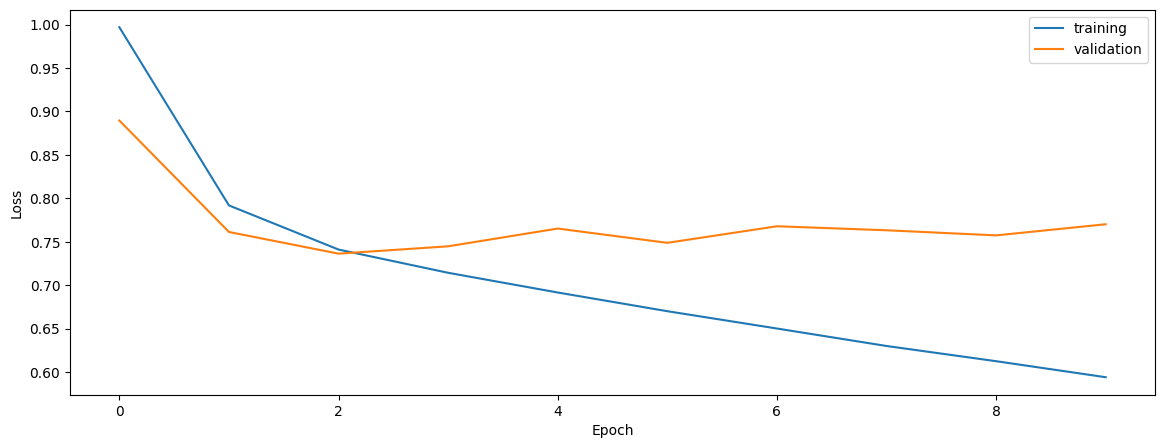

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


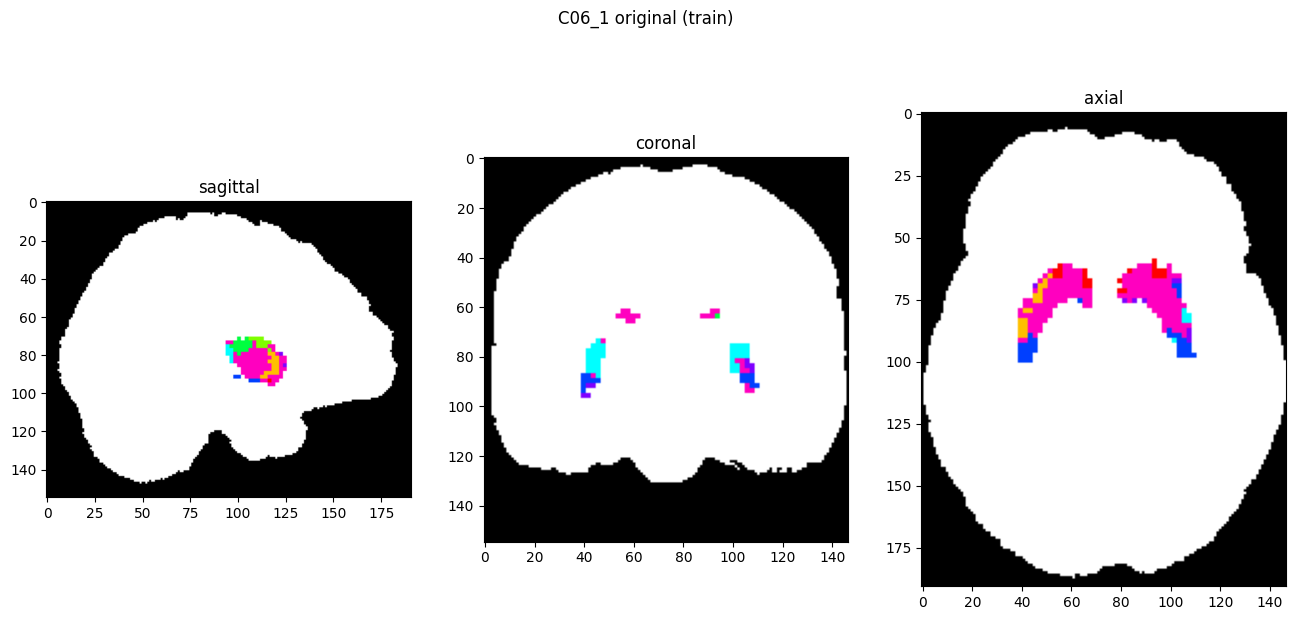

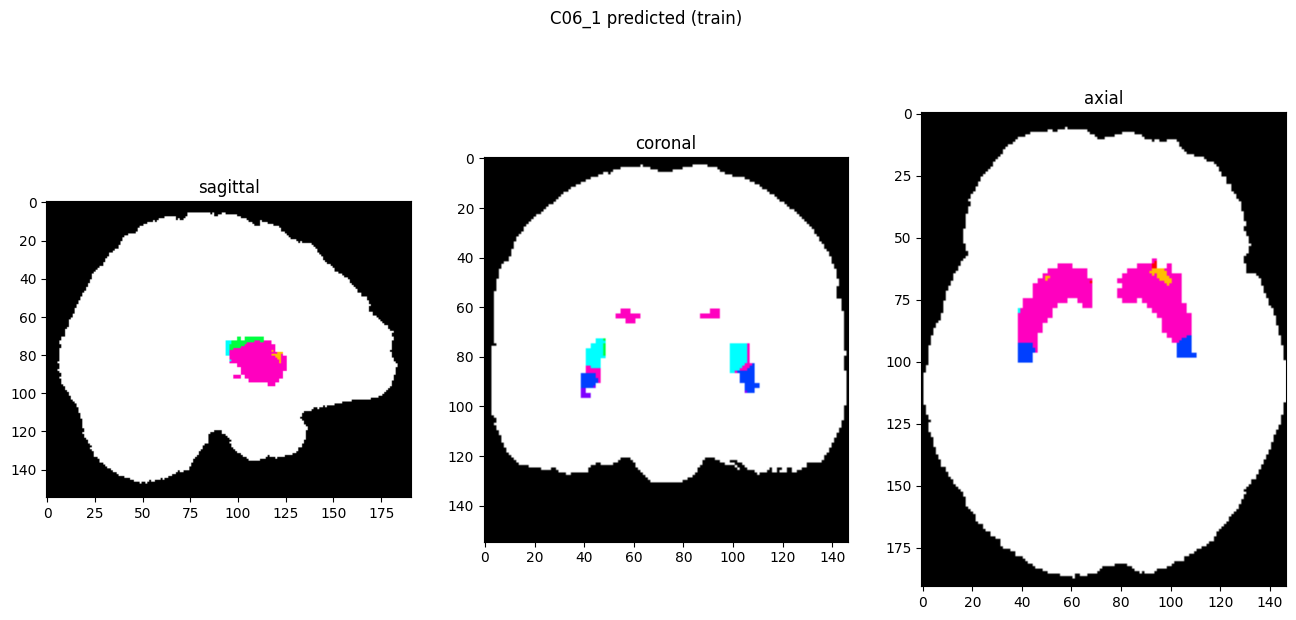

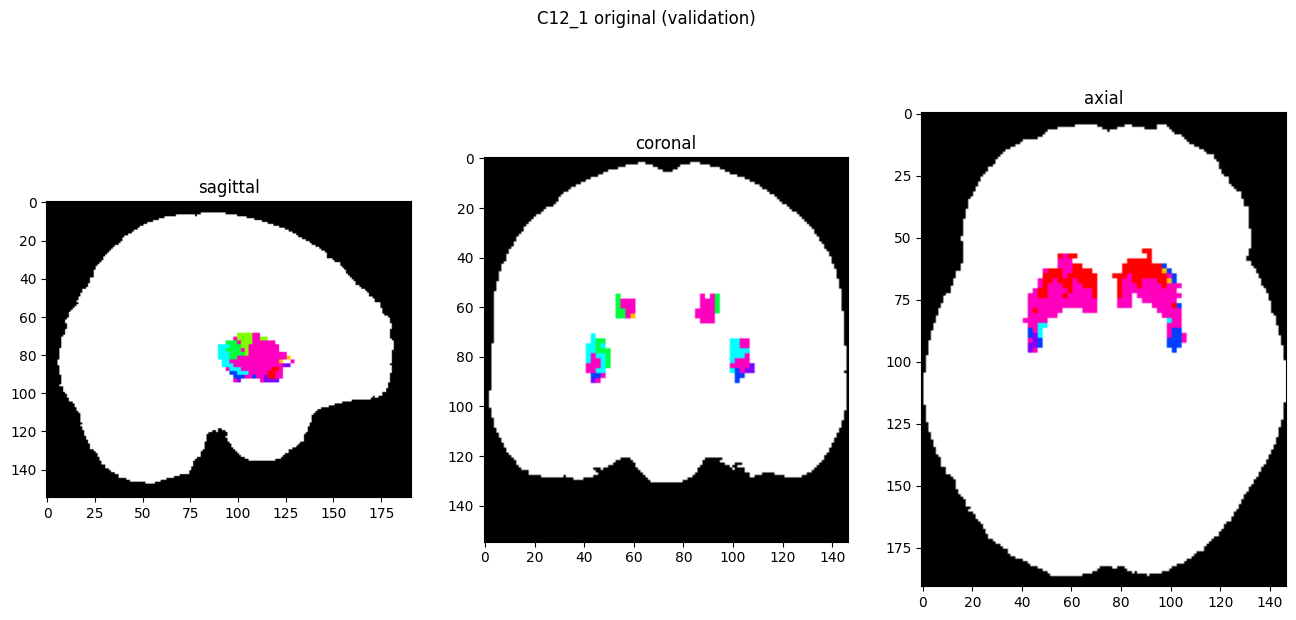

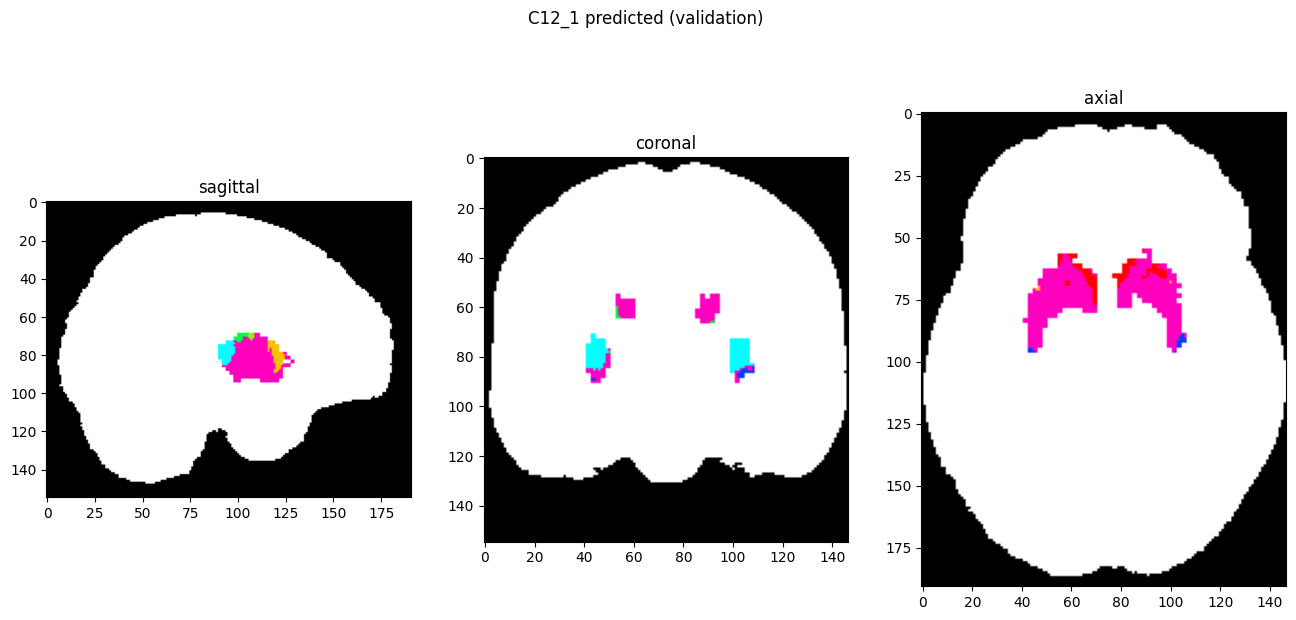

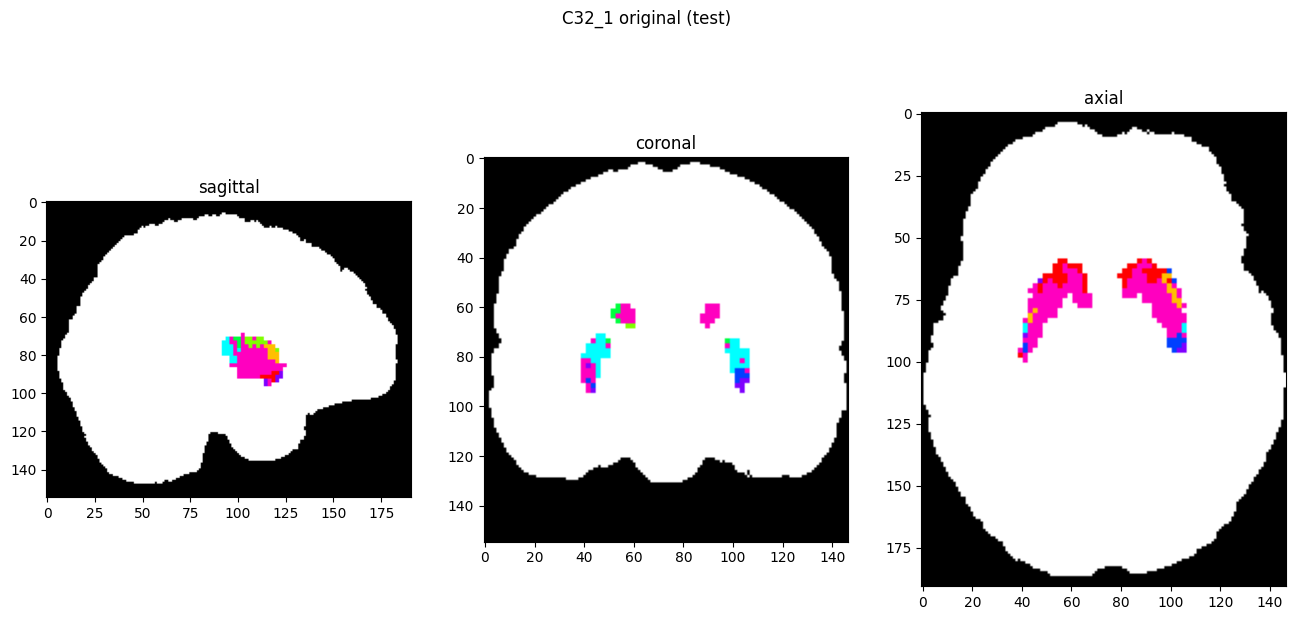

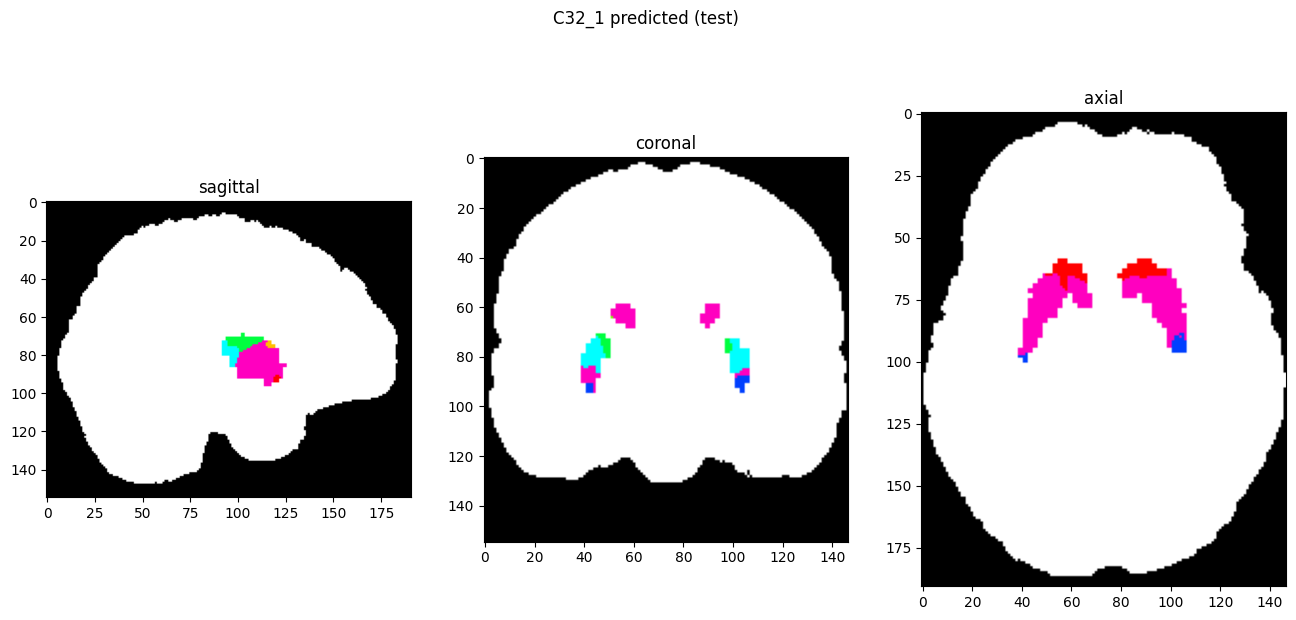

In [10]:
showResults(model, gen, threshold=0)